- LCC
- Image Preprocessing
    - Breast Cropping
    - 224 x 224 pixels
    - Data Augmentation (Random Horizontal Flip)
- Balanced datasets with around 6000 of each classes

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-03-14 15:39:18.096260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-14 15:39:18.586690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2025-03-14 15:39:19.590612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-14 15:39:19.593671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-14 15:39:19.618622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.errors import InvalidDicomError
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from collections import Counter
import numpy as np
import cv2

In [3]:
# Load the dataset
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/All_XWalk_Outcome_cleaned.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

In [4]:
# Define the correct base path
correct_base_path = "/media/yu-tingtseng_sa/Data1"

# Replace 'Q:\\' with the correct base path and standardize separators
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Replace backslashes with forward slashes

# Debugging: Print sample paths to verify
# print(data['FilePath'].head())

# Filter out rows with invalid or missing FilePath
data = data.dropna(subset=['FilePath'])  # Remove rows with NaN in FilePath
data = data[data['FilePath'].apply(lambda x: isinstance(x, str))]  # Keep only string paths

In [5]:
# Map ethnicity to 3 classes
def map_ethnicity(ethnicity):
    mapping = {
        "BR": "White", "EE": "White", "FR": "White", "NE": "White", "SE": "White", "WE": "White",
        "EA": "Asian - East and Southeast",
        "SA": "Asian - South"
    }
    return mapping.get(ethnicity, "Other")

data['ethnicity'] = data['ethnicity'].apply(map_ethnicity)

# Filter for selected ethnicities
data = data[data['ethnicity'].isin(["White", "Asian - East and Southeast", "Asian - South"])]

In [6]:
# Stratified sampling
target_per_class = 6000
asian_subgroup_target = 3000
stratified_samples = []

# Sample 6000 for White
for ethnicity, group in data.groupby('ethnicity'):
    if ethnicity == "White":
        stratified_samples.append(group.sample(
            n=min(target_per_class, len(group)), 
            random_state=42
        ))
    else:
        # Sample 3000 from each Asian subgroup
        stratified_samples.append(group.sample(
            n=min(asian_subgroup_target, len(group)), 
            random_state=42
        ))

# Combine the samples into one DataFrame
data_sample = pd.concat(stratified_samples, ignore_index=True)

# Merge Asian subgroups into one label
data_sample['ethnicity'] = data_sample['ethnicity'].replace(
    {"Asian - East and Southeast": "Asian", "Asian - South": "Asian"}
)

# Display the sample distribution
print(data_sample['ethnicity'].value_counts())

ethnicity
Asian    6000
White    6000
Name: count, dtype: int64


### Data Preprocessing

In [7]:
def preprocess(pngPath, output_dir):
    img = cv2.imread(pngPath, cv2.IMREAD_GRAYSCALE)

    # Create a binary image for the breast by thresholding
    binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)

    # Find all the contours in the binary image
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the breast region
    mask = np.zeros(img.shape, np.uint8)
    mask = cv2.fillPoly(mask, [largest_contour], 255)

    # Find the bounding box around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image
    imgCropped = img[y:y+h, x:x+w]

    # Make the cropped image square by padding
    max_dim = max(w, h)
    padded_img = cv2.copyMakeBorder(
        imgCropped,
        top=(max_dim - h) // 2,
        bottom=(max_dim - h + 1) // 2,
        left=(max_dim - w) // 2,
        right=(max_dim - w + 1) // 2,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # Background color (black)
    )

    # Save the processed image to a unique directory based on the original file path
    patient_dir = os.path.dirname(pngPath).replace("/", "_").replace("\\", "_")
    patient_output_dir = os.path.join(output_dir, patient_dir)
    os.makedirs(patient_output_dir, exist_ok=True)
    output_path = os.path.join(patient_output_dir, os.path.basename(pngPath))
    cv2.imwrite(output_path, imgCropped)
    cv2.imwrite(output_path, padded_img)

    return output_path

In [8]:
# Directory for saving preprocessed images
output_dir = "/tmp/e3/processed_images"
os.makedirs(output_dir, exist_ok=True)

# Prepare LCC-only file paths and labels
lcc_only_filepaths = []
lcc_only_labels = []

for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]
        if lcc_files:
            try:
                lcc_cropped_path = preprocess(lcc_files[0], output_dir)
                lcc_only_filepaths.append(lcc_cropped_path)
                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue
                label = matching_rows['ethnicity'].iloc[0]
                lcc_only_labels.append(label)
            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

print(f"Number of valid LCC-only images: {len(lcc_only_filepaths)}")
print(f"Distribution of valid LCC-only images: {Counter(lcc_only_labels)}")

# Split dataset into train/test
train_lcc_filepaths, test_lcc_filepaths, train_lcc_labels, test_lcc_labels = train_test_split(
    lcc_only_filepaths, lcc_only_labels, test_size=0.25, stratify=lcc_only_labels, random_state=42
)

Number of valid LCC-only images: 11978
Distribution of valid LCC-only images: Counter({'Asian': 5991, 'White': 5987})


### Convert to Labels

In [9]:
# Convert LCC labels to numeric format
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_train_lcc_labels, lcc_label_mapping = encode_labels(train_lcc_labels)
encoded_test_lcc_labels = [lcc_label_mapping[label] for label in test_lcc_labels]

# Prepare LCC-only dataset for training
def create_lcc_dataset(filepaths, labels, augment=False, targeted_classes=None):
    def load_lcc_image(filepath, label):
        # Load and resize the image
        image = tf.image.decode_png(tf.io.read_file(filepath), channels=1)
        image = tf.image.resize(image, [512, 512])

        if augment:
            # Apply horizontal flipping for all classes
            image = tf.image.random_flip_left_right(image)

        # Normalize the image to [0, 1]
        return tf.cast(image, tf.float32) / 255.0, label

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    # Apply the load_lcc_image function to each element
    dataset = dataset.map(
        lambda filepath, label: load_lcc_image(filepath, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return dataset

# Create training dataset with augmentation
train_lcc_dataset = create_lcc_dataset(
    train_lcc_filepaths, encoded_train_lcc_labels, augment=True
).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create test dataset without augmentation
test_lcc_dataset = create_lcc_dataset(
    test_lcc_filepaths, encoded_test_lcc_labels, augment=False
).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)


2025-03-14 16:08:23.840597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-14 16:08:23.841763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-14 16:08:23.842892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

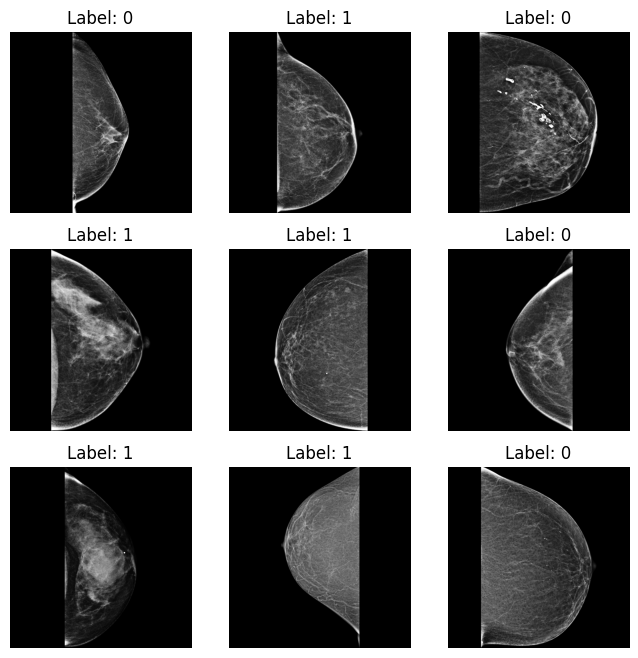

In [21]:
# Function to visualize a batch of images
def show_images_from_dataset(dataset, num_images=9):
    # Take a batch of images and labels
    for images, labels in dataset.take(1):  # Take one batch
        images = images.numpy()  # Convert Tensor to NumPy array
        labels = labels.numpy()

        # Plot images in a grid
        plt.figure(figsize=(8, 8))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')  # Squeeze in case of single-channel images
            plt.title(f"Label: {labels[i]}")
            plt.axis("off")
        plt.show()
        break  # Only take one batch

# Display a batch from the training dataset
show_images_from_dataset(train_lcc_dataset)

In [11]:
# Define input layer for 1-channel (grayscale) input
input_layer_lcc = Input(shape=(512, 512, 1))

# Convert 1-channel grayscale image to 3-channel input using a 1x1 Conv layer
x = Conv2D(3, (1, 1), activation='linear')(input_layer_lcc)

# Load EfficientNetB3 without passing input_tensor, setting input_shape instead
base_model_lcc = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Apply the grayscale conversion before passing data to EfficientNetB3
x = base_model_lcc(x)

# Freeze base model layers initially
base_model_lcc.trainable = False  

# Add custom layers on top of EfficientNetB3
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_lcc = Dense(len(lcc_label_mapping), activation='softmax')(x)

# Define the final model
model_lcc = Model(inputs=input_layer_lcc, outputs=output_lcc)

# Compile the model
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Start with a smaller learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_lcc = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)

# Fine-tuning (Unfreeze base model for additional training)
base_model_lcc.trainable = True
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train again with fine-tuning
history_finetune = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=20,  # Fewer epochs for fine-tuning
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7)
    ]
)

Epoch 1/50


2025-03-14 16:08:31.388865: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-14 16:08:32.057745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-03-14 16:08:32.083356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-03-14 16:08:32.418804: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe5700227f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-14 16:08:32.418831: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5500, Compute Capability 8.6
2025-03-14 16:08:32.418838: I tensorflow/compiler/xla/service/service.cc:176]

562/562 [==============================] - 182s 312ms/step - loss: 0.6984 - accuracy: 0.4860 - val_loss: 0.7090 - val_accuracy: 0.4998 - lr: 1.0000e-04
Epoch 2/50
562/562 [==============================] - 175s 311ms/step - loss: 0.6959 - accuracy: 0.4960 - val_loss: 0.6957 - val_accuracy: 0.4998 - lr: 1.0000e-04
Epoch 3/50
562/562 [==============================] - 175s 312ms/step - loss: 0.6945 - accuracy: 0.4929 - val_loss: 0.6951 - val_accuracy: 0.4998 - lr: 1.0000e-04
Epoch 4/50
562/562 [==============================] - 175s 311ms/step - loss: 0.6952 - accuracy: 0.4915 - val_loss: 0.6959 - val_accuracy: 0.4998 - lr: 1.0000e-04
Epoch 5/50
562/562 [==============================] - 175s 311ms/step - loss: 0.6945 - accuracy: 0.4923 - val_loss: 0.6941 - val_accuracy: 0.4998 - lr: 1.0000e-04
Epoch 6/50
562/562 [==============================] - 175s 311ms/step - loss: 0.6941 - accuracy: 0.4960 - val_loss: 0.6938 - val_accuracy: 0.4998 - lr: 1.0000e-04
Epoch 7/50
562/562 [=============

2025-03-14 17:42:03.848496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


562/562 [==============================] - 285s 452ms/step - loss: 0.6065 - accuracy: 0.6619 - val_loss: 0.6711 - val_accuracy: 0.5957 - lr: 1.0000e-05
Epoch 2/20
562/562 [==============================] - 253s 451ms/step - loss: 0.5370 - accuracy: 0.7302 - val_loss: 0.5795 - val_accuracy: 0.7152 - lr: 1.0000e-05
Epoch 3/20
562/562 [==============================] - 253s 450ms/step - loss: 0.4937 - accuracy: 0.7581 - val_loss: 0.6916 - val_accuracy: 0.5265 - lr: 1.0000e-05
Epoch 4/20
562/562 [==============================] - 254s 451ms/step - loss: 0.4580 - accuracy: 0.7870 - val_loss: 0.6882 - val_accuracy: 0.5462 - lr: 5.0000e-06
Epoch 5/20
562/562 [==============================] - 254s 452ms/step - loss: 0.4396 - accuracy: 0.7991 - val_loss: 0.7449 - val_accuracy: 0.5095 - lr: 2.5000e-06


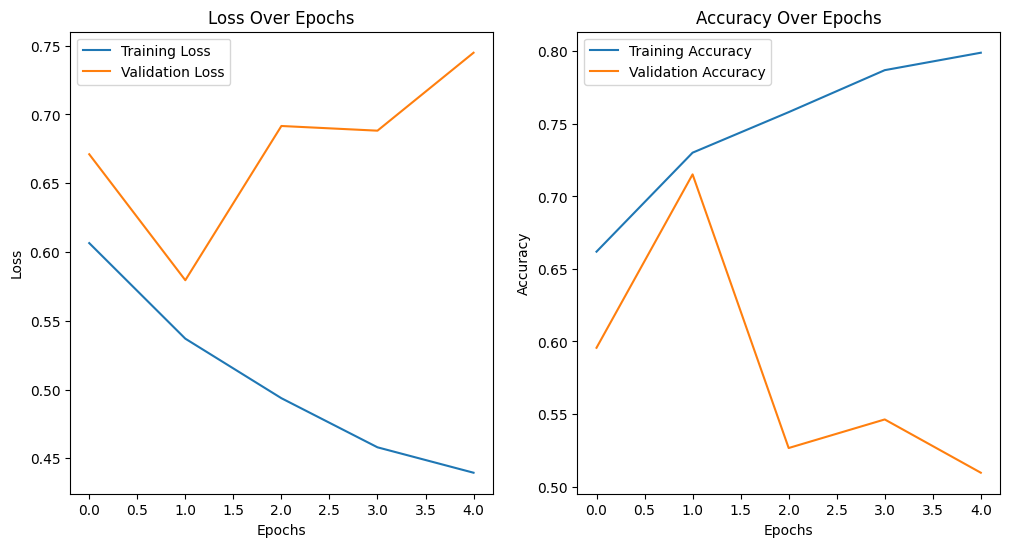

In [16]:
# Plot training and validation loss and accuracy
plt.style.use('default')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

188/188 [==============================] - 16s 87ms/step


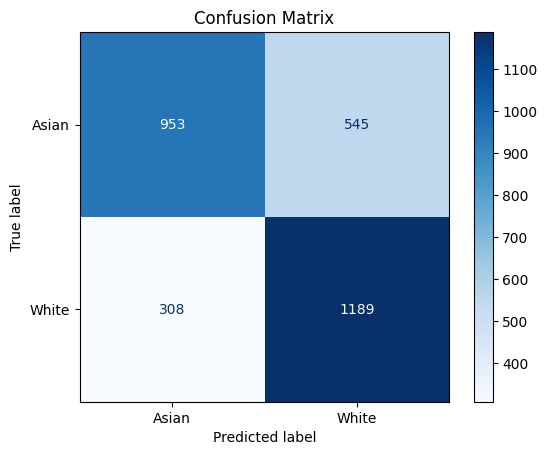

Classification Report:
              precision    recall  f1-score   support

       Asian       0.76      0.64      0.69      1498
       White       0.69      0.79      0.74      1497

    accuracy                           0.72      2995
   macro avg       0.72      0.72      0.71      2995
weighted avg       0.72      0.72      0.71      2995



In [17]:
# Evaluate the model and compute metrics
predictions = model_lcc.predict(test_lcc_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_lcc_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(lcc_label_mapping.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=list(lcc_label_mapping.keys()),
    zero_division=1  # Sets undefined metrics to 1 instead of raising warnings
))

In [14]:
# Convert confusion matrix to binary format per class
sensitivity = {}
specificity = {}

for i, class_name in enumerate(lcc_label_mapping.keys()):
    # One-vs-all approach
    TP = conf_matrix[i, i]  # True Positives
    FN = np.sum(conf_matrix[i, :]) - TP  # False Negatives
    FP = np.sum(conf_matrix[:, i]) - TP  # False Positives
    TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

    # Compute sensitivity & specificity
    sensitivity[class_name] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[class_name] = TN / (TN + FP) if (TN + FP) > 0 else 0

# Print results
print("Sensitivity (Recall) per class:")
for class_name, value in sensitivity.items():
    print(f"{class_name}: {value:.4f}")

print("\nSpecificity per class:")
for class_name, value in specificity.items():
    print(f"{class_name}: {value:.4f}")

Sensitivity (Recall) per class:
Asian: 0.6362
White: 0.7943

Specificity per class:
Asian: 0.7943
White: 0.6362


188/188 [==============================] - 16s 87ms/step
Reversed Class Mapping: {0: 'Asian', 1: 'White'}


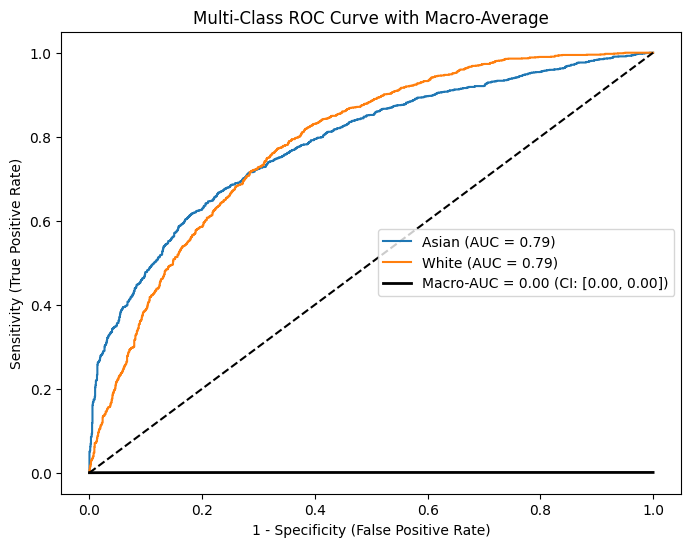


Multi-Class AUC-ROC Score per Class and Macro-AUC with CI:
              Class                          AUC
0             Asian                     0.785887
1             White                     0.785887
2     Macro_Average                     0.000525
3  Macro_Average_CI  (0.0, 0.001345060476356792)


In [19]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get softmax probabilities (required for ROC & AUC)
y_probs = model_lcc.predict(test_lcc_dataset)

# Convert true labels into a NumPy array
true_labels = np.array(true_labels)

# Binarize true labels (One-hot encoding)
num_classes = y_probs.shape[0]
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

# Reverse mapping: Now we map class indices to class names
lcc_label_reverse_mapping = {v: k for k, v in lcc_label_mapping.items()}
print("Reversed Class Mapping:", lcc_label_reverse_mapping)  # Debugging output

# Compute AUC-ROC scores for each class
auc_scores = {}
roc_data = []  # Store ROC curve data for CSV
auc_values = []  # Store AUC values for macro-average computation
mean_tpr = np.zeros(100)  # Store interpolated TPRs for macro-curve
all_fpr = np.linspace(0, 1, 100)  # Standardized FPR values

plt.figure(figsize=(8, 6))

# Ensure correct mapping of class indices
for class_index in sorted(lcc_label_reverse_mapping.keys()):  # Now using numeric indices
    class_name = lcc_label_reverse_mapping[class_index]  # Get correct class name

    fpr, tpr, _ = roc_curve(true_labels_bin[:, class_index], y_probs[:, class_index])
    roc_auc = auc(fpr, tpr)
    
    auc_scores[class_name] = roc_auc
    auc_values.append(roc_auc)

    # Interpolate TPR for macro-AUC curve
    mean_tpr += np.interp(all_fpr, fpr, tpr)

    # Save ROC curve data
    for j in range(len(fpr)):
        roc_data.append([class_name, fpr[j], tpr[j]])

    # Plot each class ROC curve
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Compute Macro-Averaged AUC
mean_tpr /= num_classes  # Average the TPRs
macro_auc = auc(all_fpr, mean_tpr)

# Compute 95% CI for Macro-AUC
n_total = len(true_labels)
se_macro_auc = np.sqrt((macro_auc * (1 - macro_auc)) / n_total)
ci_macro_lower = max(macro_auc - 1.96 * se_macro_auc, 0.0)
ci_macro_upper = min(macro_auc + 1.96 * se_macro_auc, 1.0)

# Save macro AUC
auc_scores["Macro_Average"] = macro_auc
auc_scores["Macro_Average_CI"] = (ci_macro_lower, ci_macro_upper)

# Plot Macro-AUC Curve
plt.plot(all_fpr, mean_tpr, color='black', linestyle='-', linewidth=2,
        label=f'Macro-AUC = {macro_auc:.2f} (CI: [{ci_macro_lower:.2f}, {ci_macro_upper:.2f}])')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Multi-Class ROC Curve with Macro-Average')
plt.legend()
plt.show()

# Save AUC & ROC data to CSV (for R processing)
roc_df = pd.DataFrame(roc_data, columns=['Class', '1 - Specificity (False Positive Rate)', 'Sensitivity (True Positive Rate)'])
auc_df = pd.DataFrame(auc_scores.items(), columns=['Class', 'AUC'])

roc_df.to_csv("ROC_Data.csv", index=False)
auc_df.to_csv("AUC_Scores.csv", index=False)

print("\nMulti-Class AUC-ROC Score per Class and Macro-AUC with CI:")
print(auc_df)

In [20]:
# Save the model
model_lcc.save('Mammo_EfficientNetB3_2class_512_model.h5')

/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
